In [3]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
#from qbmqsp.qbm import QBM
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from gen_data import xxz_gibbs_state, basis_encoding, gen_boltzmann_dist, gen_discrete_gauss_dist
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl

import pennylane as qml
from pennylane import numpy as np
from pennylane.pauli.utils import string_to_pauli_word

from qbmqsp.hamiltonian import Hamiltonian
from qbmqsp.qsp_phase_engine import QSPPhaseEngine
from qbmqsp.qevt import QEVT
from qbmqsp.rel_ent import relative_entropy



import itertools


DATASET_PATH2='C:/Users/ge84gac/Downloads/QBM-Anomaly-Detection-version-paper/QBM-Anomaly-Detection-main/src/datasets/l_o7_c5_d3_p200_v1.npy'
DATASET_PATH = 'C:/Users/ge84gac/QBM-anomaly-detection/src/datasets/l_o6_c10_d3_p1000_2.npy'   # Give dataset path
CLUSTER = 5

In [4]:
# Function returning the hamilatonian form for the restriceted boltzmann machine

In [5]:
def generate_pauli_strings_tfim(num_qubits,n_visible,restricted=True):
    """
    Generate Pauli strings for a transverse field Ising model as a 
    restricted boltzmann machine with no visible-visible connecions.
    
    Parameters:
    num_qubits (int): Number of qubits in the quantum Boltzmann machine.
    n_visible (int): Number if visible units.
    
    Returns:
    list: List of Pauli strings representing the Hamiltonian.
    """
    pauli_strings = []

    # Local transverse field terms (X_i)
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_strings.append(''.join(pauli_string))

    # Interaction terms (Z_i Z_j)
    for i, j in itertools.combinations(range(num_qubits), 2):
        if restricted:
            if i<n_visible and j>=n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))
        else:
            if i<n_visible:
                pauli_string = ['I'] * num_qubits
    
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                pauli_strings.append(''.join(pauli_string))       
    return pauli_strings

generate_pauli_strings_tfim(7,3,False)   

['ZIIIIII',
 'IZIIIII',
 'IIZIIII',
 'IIIZIII',
 'IIIIZII',
 'IIIIIZI',
 'IIIIIIZ',
 'ZZIIIII',
 'ZIZIIII',
 'ZIIZIII',
 'ZIIIZII',
 'ZIIIIZI',
 'ZIIIIIZ',
 'IZZIIII',
 'IZIZIII',
 'IZIIZII',
 'IZIIIZI',
 'IZIIIIZ',
 'IIZZIII',
 'IIZIZII',
 'IIZIIZI',
 'IIZIIIZ']

In [10]:


class QBM():
    """Quantum Boltzmann machine (QBM) based on quantum signal processing.

    Parameters
    ----------
    β, enc:
        Same as attributes.
    h, θ:
        See qbmqsp.hamiltonian.Hamiltonian
    δ, polydeg:
        See qbmqsp.qsp_phase_engine.QSPPhaseEngine

    Attributes
    ----------
    β : float
        Inverse temperature.
    enc : str in {'general', 'lcu'}
        Unitary block encoding scheme.
    H : qbmqsp.hamiltonian.Hamiltonian
        Constructed from parameters (h, θ).
    qsp : qbmqsp.qsp_phase_engine.QSPPhaseEngine
        Constructed from parameters (δ, polydeg).
    qevt : qbmqsp.qevt.QEVT
        Quantum eigenvalue transform to realize matrix function f(A) = exp(- τ * |A|). Updated after each training epoch.
    observables : qml.operation.Observable
        Observables w.r.t which the QBM is measured to optimize via gradient descent.
    aux_wire, enc_wires, sys_wires, env_wires : list[int]
        Quantum register wires of quantum circuit that prepares and measures the QBM.
    """
    
    
    
    
    
    def __init__(self,data,h: list[str], θ: np.ndarray[float], enc: str, δ: float, polydeg: int, β: float, hnodes,epochs=1,restricted=True) -> None:
        if β < 0:
            raise ValueError("__init__: β must not be negative.")
        
        self.epochs=epochs
        self.β = β
        self.enc = enc
        self.H = Hamiltonian(h, θ)
        self.qsp = QSPPhaseEngine(δ, polydeg)
        self.qevt = self._construct_qevt()
        self.aux_wire, self.enc_wires, self.sys_wires, self.env_wires = self._construct_wires()
        self.observables = self._construct_obervables()
        
        self.encoded_data, bits_input_vector, num_features = self.binary_encode_data(data, use_folding=True)
        self.dim_input = bits_input_vector * num_features
        self.quantile=0.95
        self.dim_input=n_visible
        self.n_hidden_nodes=hnodes
        
        self.qubits=self.dim_input+self.n_hidden_nodes
        
        self.restricted=restricted
        # weights and biases in terms of the parameter θ
        
        #self.weights_visible_to_hidden=np.reshape(θ[self.n_hidden_nodes+self.dim_input:],(self.dim_input,self.n_hidden_nodes))
        
        #self.biases_visible=θ[0:self.dim_input]
        
        #self.biases_hidden=θ[self.dim_input:self.n_hidden_nodes+self.dim_input]

    def get_binary_cluster_points(self,dataset, cluster_index: int) -> np.ndarray:
        points = np.array([entry[:-1]
                           for entry in dataset if entry[-1] <= cluster_index])

        return self.binary_encode_data(points, use_folding=False)[0]
    
    def get_binary_outliers(self,dataset, outlier_index: int):
        outliers = np.array([entry[:-1]
                            for entry in dataset if entry[-1] >= outlier_index])

        return self.binary_encode_data(outliers, use_folding=False)[0]
  
    def binary_encode_data(self,data, use_folding=False):
        """ Encode a numpy array of form [[numpy.int64 numpy.int64] ...] into a
        list of form [[int, int, int, ...], ...].
        Example: encode [[107  73] [113  90] ...] to
        [[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0] .
        """

        # find out how many bits we need for each feature
        number_bits = len(np.binary_repr(np.amax(data)))
        number_features = data.shape[1]

        binary_encoded = ((data.reshape(-1, 1) & np.array(2 **
                          np.arange(number_bits-1, -1, -1))) != 0).astype(np.float32)
        if use_folding:
            return binary_encoded.reshape(len(data), number_features*number_bits), number_bits, number_features
        else:
            return binary_encoded.reshape(len(data), number_features, number_bits), number_bits, number_features
    
    
    def n_qubits(self, registers: str | set[str] = None) -> int:
        """Return number of qubits per registers.
        
        Parameters
        ----------
        registers : str | set[str]
            Quantum registers whose number of qubits should be returned.
            Must be an element from or a subset of {'aux', 'enc', 'sys', 'env'}.

        Returns
        -------
        n : int
            Number of qubits used per registers.
        """
        if registers is None:
            registers = {'aux', 'enc', 'sys', 'env'}
        elif type(registers) == str:
            registers = {registers}
        if not registers.issubset({'aux', 'enc', 'sys', 'env'}):
            raise ValueError("n_qubits: registers must be an element from or a subset of %r." % {'aux', 'enc', 'sys', 'env'})
        
        n = 0
        if 'env' in registers:
            n += self.qevt.n_qubits('sys')
        registers.discard('env')
        if len(registers) != 0:
            n += self.qevt.n_qubits(registers)
        return n

    def _generate_qsp_phases(self) -> np.ndarray[float]:
        τ = self.β / (1-self.qsp.δ) * self.H.θ_norm()
        φ = self.qsp.generate(τ)
        return φ

    def _construct_qevt(self) -> QEVT:
        φ = self._generate_qsp_phases()
        h_δ, θ_δ = self.H.preprocessing(self.qsp.δ)
        return QEVT(h_δ, θ_δ, self.enc, φ)
    
    def _construct_wires(self) -> tuple[list[int], list[int], list[int], list[int]]:
        wires = list(range(self.n_qubits()))
        aux_wire = wires[: self.n_qubits('aux')]
        enc_wires = wires[self.n_qubits('aux') : self.n_qubits({'aux', 'enc'})]
        sys_wires = wires[self.n_qubits({'aux', 'enc'}) : self.n_qubits({'aux', 'enc', 'sys'})]
        env_wires = wires[self.n_qubits({'aux', 'enc', 'sys'}) : self.n_qubits({'aux', 'enc', 'sys', 'env'})]
        return aux_wire, enc_wires, sys_wires, env_wires

    def _construct_obervables(self) -> list[qml.operation.Observable]:
        n_aux_enc = self.n_qubits({'aux', 'enc'})
        aux_enc_wires = self.aux_wire + self.enc_wires
        proj0 = qml.Projector( [0] * n_aux_enc, aux_enc_wires)

        new_sys_wires = list(range(self.n_qubits('sys')))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        observables = [proj0] + [proj0 @ string_to_pauli_word(self.H.h[i], wire_map) for i in range(self.H.n_params)]
        return observables
    
    def _bell_circuit(self) -> None:
        for i, j in zip(self.sys_wires, self.env_wires):
            qml.Hadamard(i)
            qml.CNOT([i, j])

    def probabilistic(self):
        
        bit_strings=[]
        for i in range(2**(self.n_hidden_nodes+self.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes+self.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
        sample = random.choices(bit_strings, k=1)

        for i,x in enumerate(sample[0]):
            if x==1:
                qml.PauliX(wires=[self.sys_wires[i]])
    
    def _prepare(self) -> None:
        self._bell_circuit()
        #self.probabilistic()
        self.qevt.circuit(self.aux_wire, self.enc_wires, self.sys_wires)
    
    def _measure(self) -> None:
        #return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        return [qml.expval(self.observables[i]) for i in range(len(self.observables))]
    
    
    def get_sample(self,shots=1):
        dev = qml.device(dev_name,shots=shots, wires=self.n_qubits({'aux','enc','sys'}))
        @qml.qnode(dev)
        
        def quantum_circuit():
            
            self._prepare()
            return qml.sample(wires=self.aux_wire+self.enc_wires+self.sys_wires)
        
        sample=quantum_circuit()
        return sample
    
    def get_average_configuration_from_samples(self, samples: list, input_vector=None):
        ''' Takes samples from Annealer and averages for each neuron and connection
        '''

        # unclamped if input_vector == None
        unclamped = input_vector== None

        # biases (row = sample, column = neuron)
        np_samples = np.vstack(
            tuple([np.array(list(sample.values())) for sample in samples]))
        avgs_biases = np.average(np_samples, axis=0)
        avgs_biases_hidden = avgs_biases[self.dim_input:] if unclamped else avgs_biases
        avgs_biases_visible = avgs_biases[:
                                          self.dim_input] if unclamped else input_vector

        # weights
        avgs_weights_visible_to_hidden = np.zeros(
            self.weights_visible_to_hidden.shape)
        if not self.restricted:
            avgs_weights_visible_to_visible = np.zeros(
                self.weights_visible_to_visible.shape)
        for v in range(self.dim_input):
            # visible to hidden connections
            for h in range(self.n_hidden_nodes):
                x, y = (np_samples[:, v], self.dim_input +
                        h) if unclamped else (input_vector[v], h)
                avgs_weights_visible_to_hidden[v, h] = np.average(
                    x*np_samples[:, y])
            # visible to visible connections
            if not self.restricted:
                for v2 in range(v, self.dim_input):
                    x, y = (np_samples[:, v], np_samples[:, v2]) if unclamped else (
                        input_vector[v], input_vector[v2])
                    avgs_weights_visible_to_visible[v, v2] = np.average(x*y)

        if self.restricted:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, None
        else:
            return avgs_biases_hidden, avgs_biases_visible, avgs_weights_visible_to_hidden, avgs_weights_visible_to_visible

    def _compute_expvals(self) -> np.ndarray[float]:
        dev = qml.device(dev_name,wires=self.n_qubits({'aux','enc','sys','env'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
        @qml.qnode(dev)
        
        def quantum_circuit():
            self._prepare()
            return self._measure()
        num_repetitions=1
        avg_measurements=np.zeros(self.H.n_params)
        for repetitions in range(num_repetitions):
            
            measurements = quantum_circuit()
            
            success_probabilty = measurements[0]
            
            
            qbm_expvals = measurements[1:] / success_probabilty
            
            avg_measurements+=qbm_expvals
            
            print(success_probabilty, "prob")
        
        
        avg_measurements=avg_measurements/float(num_repetitions)
        
       
        return avg_measurements
    
    def _loss_func(self, ρ0: np.ndarray[float], ρ1: np.ndarray[float]) -> float:
        return relative_entropy(ρ0, ρ1, check_state=True).item()
    
    def assemble(self) -> np.ndarray[float]:
        """Assemble QBM."""
        expH = spl.expm(-self.β * self.H.assemble())
        return expH / np.trace(expH)
    
    
    def get_energy(self,input_vector):
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(input_vector,self.weights_visible_to_hidden).flatten()
        
        
    # List to store all bit strings
        bit_strings=[]
        p=[]
    # There are 2^n bit strings of length n
        print(new_biases)
        for i in range(2**self.n_hidden_nodes):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(self.n_hidden_nodes)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            p.append(np.exp(-self.β*np.dot(bit_list,new_biases)))

        p=np.array(p)
        probabilities=p/np.sum(p)
        sample = random.choices(bit_strings, weights=probabilities, k=1)

        return self.β*np.dot(sample,new_biases)
            

               

            
     
    
    def free_energy(self, input_vector):
        '''Function to compute the free energy'''

        # calculate hidden term
        
         
         
        hidden_term = self.get_energy(input_vector)

        # calculate visible_term
        # visible bias
        visible_term = self.β*np.dot(
            input_vector, self.H.θ[:self.dim_input]) #/beta
        
        

        return hidden_term + visible_term
    
    def calculate_outlier_threshold(self, quantile=0.95):
        self.quantile = quantile
        energies = np.apply_along_axis(
            self.free_energy, axis=1, arr=self.encoded_data)
        self.outlier_threshold = np.quantile(energies, self.quantile)
    
    
    
    
    
    def get_average_configurations(self,input_vector=None):
        '''
        Function for giving averge configurations of all qubits for the gibbs state of the system.
        Gives configuration over hidden units only, if input vector is clamped at a certain value.
       
    
        Parameters:
        input vector (np.ndarray)
        
    
        Returns:
        list: List of expectation values of hamilatonian terms.
        '''
        
        
        # unclamped values
        if input_vector is None:
            
            qbm_expvals=self._compute_expvals()
            
            return qbm_expvals
        
        # clamped values
        
        
        if self.restricted:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes:],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        else:
            self.weights_visible_to_hidden=np.reshape(self.H.θ[self.dim_input+self.n_hidden_nodes+self.dim_input*(self.dim_input-1):],(self.dim_input,self.n_hidden_nodes))
            self.biases_hidden=self.H.θ[self.dim_input:self.dim_input+self.n_hidden_nodes]
            self.biases_visible=self.H.θ[:self.dim_input]
        
        input_vector=[input_vector]
        new_biases=self.biases_hidden+np.matmul(input_vector,self.weights_visible_to_hidden).flatten()
        #np.matmul(input_vector, self.weights_visible_to_hidden).flatten()
        
        Q_new=new_biases

        exp_vals=-np.tanh(self.β*new_biases/2)
        return exp_vals
            
        '''
        
        β, δ, θ_norm = self.β, 0.3, np.linalg.norm(Q_new, ord=1)
        τ = β * θ_norm / (1-δ)
        
        φ = self.qsp.generate(τ)
        #del qsp_phase_engine
         
      
        # New energy configuration only for hidden units
        h=generate_pauli_strings_tfim(self.n_hidden_nodes,self.n_hidden_nodes)
        
        h_δ = h + [self.n_hidden_nodes * 'I']
        θ_δ = np.append(Q_new * (1-δ)/(2*θ_norm), (1+δ)/2)
        encoding='general' 
        qevt = QEVT(h_δ, θ_δ, encoding, φ)
        
        
        
        n_aux, n_enc, n_sys = qevt.n_qubits({'aux'}), qevt.n_qubits({'enc'}), qevt.n_qubits({'sys'})
        wires = list(range(n_aux + n_enc + 2*n_sys))
        aux_wire = wires[: n_aux]
        enc_wires = wires[n_aux : n_aux+n_enc]
        sys_wires = wires[n_aux+n_enc : n_aux+n_enc+n_sys]
        env_wires=wires[n_aux+n_enc+n_sys:]
        
        new_sys_wires = list(range(n_sys))
        wire_map = dict(zip(self.sys_wires, new_sys_wires))
        proj0 = qml.Projector( [0] * (n_aux+n_enc), aux_wire+enc_wires)
        observables = [proj0] + [proj0 @ string_to_pauli_word(h[i], wire_map) for i in range(len(h))]
        
        
        dev = qml.device(dev_name, wires=n_aux+n_enc+2*n_sys)
        #dev = qml.device(, backend=backend,wires=n_aux+n_enc+2*n_sys,ibmqx_token=token)
        @qml.qnode(dev)
        
        
        def qevt_circuit():
            for i, j in zip(sys_wires, env_wires):
                qml.Hadamard(i)
                qml.CNOT([i, j])
            qevt.circuit(aux_wire, enc_wires, sys_wires)
            return [qml.expval(observables[i]) for i in range(len(observables))]
       
        measurements = qevt_circuit()
        success_probabilty = measurements[0]
        qbm_expvals = measurements[1:] / success_probabilty    
        
        return qbm_expvals
    
        '''
                
    def train_for_one_iteration(self, batch, learning_rate):

        errors = 0
        #errors_biases_visible = 0
        #errors_weights_visible_to_hidden = 0
        #if not self.restricted:
          #  errors_weights_visible_to_visible = 0

        for i,input_vector in enumerate(batch):
            
            
            if i==0:
                unclamped_config = self.get_average_configurations() 
                print(unclamped_config)
            
            clamped_config = self.get_average_configurations(input_vector) # has only expectations over hidden units
            
            # avgs_weights_visible_to_visible_clamped only has a value if not restricted
            print(clamped_config)
            
            # Getting averages for all qubits , avg_visible=input_vector
            
            full_clamped_config=np.zeros_like(unclamped_config)
            
            full_clamped_config[:self.dim_input]=2*input_vector-1    
            full_clamped_config[self.dim_input:self.dim_input+self.n_hidden_nodes]=clamped_config
            
            pos_neg=2*input_vector-1
            if self.restricted:
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes:]=np.kron(pos_neg,clamped_config)
            
            else:
                
                
                
                full_clamped_config[self.dim_input+self.n_hidden_nodes: self.dim_input+self.n_hidden_nodes+self.dim_input*(self.dim_input-1)]=np.array([pos_neg[j]*pos_neg[i] for j in range(len(pos_neg)) for i in range(j+1,len(pos_neg))])
                full_clamped_config[self.dim_input+self.n_hidden_nodes+self.dim_input*(self.dim_input-1):]=np.kron(pos_neg,clamped_config)
            
            
            errors += full_clamped_config - unclamped_config
            
            
            
            
            
            
            

        errors /= batch.shape[0]
        
        self.H.θ = self.H.θ - learning_rate * errors
                
        self.qevt = self._construct_qevt()
                
       
        
        
        return np.average(errors)
    
    
    
    
    def train_model(self, batch_size=8, learning_rate=0.005):
        
        data = self.encoded_data
        
        batch_num = data.shape[0] // batch_size
        diff = data.shape[0] % batch_size
        if diff:
            
        
            data = data[:-diff]
            last_batch = data[data.shape[0] - diff:]
        
        
        
        batches = np.vsplit(data, batch_num)
        
        if diff:
            batches.append(last_batch)
              
        losses=[]
        
        for epoch in range(1, self.epochs+1):
            print(f'Epoch {epoch}')
            batch_errors = None
            batchnum = 1
            errors_f=[]
            for batch in tqdm(batches):
                    
                    errors = self.train_for_one_iteration(batch, learning_rate)
                    print(errors)
                    if type(batch_errors) is np.ndarray:
                        batch_errors = np.hstack((batch_errors, errors))
                    else:
                        batch_errors = errors
                    #self.save_weights(
                        #f'e{epoch}_b{batchnum}_{self.paramstring}')
                    batchnum += 1
               
                    #self.save_weights(
                     #   f'e{epoch}_b{batchnum}_{self.paramstring}')
                    #raise e
                    errors_f.append(errors)
        
        
        losses.append(errors_f)
        self.calculate_outlier_threshold(self.quantile)
        return losses  
    #self.error_container.add_error(batch_errors)
        #self.error_container.plot("qbm_errors" + self.paramstring)
        #self.save_weights(title="final_weights_qbm" + self.paramstring)
        # make list of values of the error dicts
        
        #self.calculate_outlier_threshold(self.quantile)
       
    def predict_point_as_outlier(self, input):
        energy = self.free_energy(input)
        if energy >= self.outlier_threshold:
            return 1, energy
        return 0, energy
        
    
        
        
    
        
    

    

In [ ]:

#dev_name='qiskit.ibmq'
data = import_dataset(DATASET_PATH2)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)

print(training_labels[0::10])
import numpy
training_data=numpy.expand_dims(training_data[:,0],axis=1)
training_data=training_data[0::10]
n_hidden_units=3
n_visible=7
n_qubits = n_visible+n_hidden_units

restricted=True
h = generate_pauli_strings_tfim(n_qubits,n_visible,restricted)
print(h)
nparams = len(h)
np.random.seed(seed=1)
θ_init = np.random.rand(nparams)/nparams
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.0
learning_rate = 0.003
epochs = 1


dev_name='default.qubit'
#dev_name='lightning.qubit'

qbm = QBM(training_data,h, θ_init, enc, δ, polydeg, β,n_hidden_units,epochs,restricted)

errors=qbm.train_model(1,learning_rate)

[ 1  0  2  4  1  4  1  1  3  2  3 10  1  4  0  4  0  4  1  1  3  4  3  2
  4  0  0  1  3  4  0  0  0  1  4  2  1  3  0  0  2  0  4  0  1  2  0  0
  2  0  3]
['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ', 'IZIIIIIZII', 'IZIIIIIIZI', 'IZIIIIIIIZ', 'IIZIIIIZII', 'IIZIIIIIZI', 'IIZIIIIIIZ', 'IIIZIIIZII', 'IIIZIIIIZI', 'IIIZIIIIIZ', 'IIIIZIIZII', 'IIIIZIIIZI', 'IIIIZIIIIZ', 'IIIIIZIZII', 'IIIIIZIIZI', 'IIIIIZIIIZ', 'IIIIIIZZII', 'IIIIIIZIZI', 'IIIIIIZIIZ']

Starting MATLAB engine.. Done.


Stopping MATLAB engine ... Done.

Epoch 1


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

0.4550228909574129 prob
[-1.33789650e-02 -2.35164110e-02  8.92991639e-04 -8.54780411e-03
 -3.26023346e-03 -2.41596660e-03 -5.55509987e-03 -9.81487910e-03
 -1.22279664e-02 -1.65937519e-02 -1.40491699e-02 -2.32583386e-02
 -6.34775000e-03 -2.97727735e-02 -6.71835974e-05 -2.22662836e-02
 -1.43142581e-02 -1.92008343e-02 -4.63954555e-03 -6.40189623e-03
 -2.72744801e-02 -3.29902150e-02 -1.05560551e-02 -2.36390350e-02
 -2.99949840e-02 -3.08284154e-02 -2.70586493e-03 -1.08254626e-03
 -5.57417195e-03 -3.01572929e-02 -2.91799294e-03]
[-0.03500001 -0.04287851 -0.04234522]


  2%|█▋                                                                                 | 1/51 [00:16<13:36, 16.32s/it]

0.038451925720251835
0.4581043377455562 prob
[-1.01280546e-02 -2.67109270e-02 -2.35978082e-03 -5.31611737e-03
 -4.02198820e-05  8.21288013e-04 -8.79718921e-03 -9.92756516e-03
 -1.24851542e-02 -1.69035238e-02 -1.41700334e-02 -2.33776979e-02
 -6.54123402e-03 -2.94957869e-02  1.74962701e-04 -2.19570687e-02
 -1.40703504e-02 -1.89178778e-02 -4.35138087e-03 -6.53328615e-03
 -2.73814658e-02 -3.31190845e-02 -1.06818444e-02 -2.37537681e-02
 -3.01297943e-02 -3.09102906e-02 -2.88975555e-03 -1.29899846e-03
 -5.35707036e-03 -2.98561666e-02 -2.63085829e-03]
[-0.02328061 -0.02081303 -0.02504694]


  4%|███▎                                                                               | 2/51 [00:32<13:11, 16.16s/it]

-0.07847170142209407
0.4467116482562444 prob
[-0.01325586 -0.02974153 -0.00554017 -0.00200741 -0.00324457  0.00404433
 -0.01192738 -0.00978079 -0.01215259 -0.01678044 -0.01400983 -0.02315382
 -0.00642625 -0.02920949  0.00019623 -0.02167568 -0.01389918 -0.01872058
 -0.00423798 -0.00677354 -0.02748072 -0.03322102 -0.01057199 -0.02356744
 -0.02984102 -0.03090181 -0.00308768 -0.00155882 -0.00525293 -0.02957052
 -0.00254195]
[-0.05237235 -0.03924495 -0.03961972]


  6%|████▉                                                                              | 3/51 [00:48<12:44, 15.93s/it]

0.09390143243104133
0.4489886122142126 prob
[-1.00172315e-02 -2.64767179e-02 -2.32168347e-03 -5.26507764e-03
 -1.55653350e-05  7.23272501e-03 -1.51363905e-02 -1.04309673e-02
 -1.22329268e-02 -1.69802542e-02 -1.42008150e-02 -2.32792028e-02
 -6.62359150e-03 -2.93721935e-02  2.34973128e-05 -2.18300154e-02
 -1.40894540e-02 -1.88609072e-02 -4.43968155e-03 -6.45844565e-03
 -2.71757484e-02 -3.28667208e-02 -1.07451385e-02 -2.37086358e-02
 -2.99989527e-02 -3.10606741e-02 -3.26137968e-03 -1.75676486e-03
 -4.99625251e-03 -2.93035903e-02 -2.28937673e-03]
[-0.01759109 -0.02868194 -0.02620945]


  8%|██████▌                                                                            | 4/51 [01:03<12:27, 15.90s/it]

-0.07829344890893002
0.44581992883133315 prob
[-0.00673476 -0.0295588  -0.00550927 -0.00845657  0.00324247  0.0040007
 -0.01827544 -0.01012235 -0.01215951 -0.01690069 -0.01428857 -0.02336465
 -0.00682258 -0.02913138  0.00015336 -0.02157165 -0.01392449 -0.01863451
 -0.00426367 -0.00635358 -0.0269085  -0.03255109 -0.01088751 -0.02383159
 -0.03011905 -0.03080941 -0.0031086  -0.00158971 -0.0048666  -0.0290297
 -0.00211765]
[-0.03763786 -0.05666716 -0.04375961]


 10%|████████▏                                                                          | 5/51 [01:19<12:12, 15.93s/it]

0.09297538075525019
0.4430941920889722 prob
[-0.00353437 -0.0326477  -0.00873681 -0.00526034  0.00637984  0.00716829
 -0.01500535 -0.01027677 -0.01279547 -0.01716793 -0.01440645 -0.02349751
 -0.0070323  -0.02880511  0.00038104 -0.02123617 -0.01366875 -0.01829328
 -0.00400441 -0.0065193  -0.02701944 -0.03262329 -0.01102497 -0.02394957
 -0.03020257 -0.03083648 -0.00333997 -0.00183214 -0.00504159 -0.02913659
 -0.00236376]
[-0.02029685 -0.04269932 -0.02779528]


 12%|█████████▊                                                                         | 6/51 [01:35<11:46, 15.69s/it]

-0.018505509262697117
0.4417981443325259 prob
[-0.00031252 -0.03571541 -0.01191105 -0.00847253  0.00957874  0.00393347
 -0.01174462 -0.0100229  -0.01311409 -0.01707619 -0.01449695 -0.0236201
 -0.00721092 -0.02856495  0.0005672  -0.02097993 -0.01348835 -0.01802795
 -0.00381087 -0.00638392 -0.02669257 -0.03228926 -0.01115989 -0.02408438
 -0.03030909 -0.03057881 -0.0031243  -0.00165305 -0.0051594  -0.02922767
 -0.00255547]
[-0.03780411 -0.05694715 -0.04396445]


 14%|███████████▍                                                                       | 7/51 [01:50<11:24, 15.56s/it]

0.0926724170276768
0.4362819570617359 prob
[ 0.00284826 -0.03870932 -0.01506982 -0.00527172  0.01266441  0.00708087
 -0.00850341 -0.01018637 -0.01373216 -0.01734372 -0.01460591 -0.02372952
 -0.007421   -0.02821795  0.00077187 -0.02063121 -0.01323774 -0.01769027
 -0.00357289 -0.00655949 -0.02678847 -0.03234329 -0.01129198 -0.024185
 -0.03036826 -0.03057927 -0.00335875 -0.00189992 -0.00533401 -0.02930066
 -0.00280422]
[-0.03802732 -0.05727879 -0.04422299]


 16%|█████████████                                                                      | 8/51 [02:05<11:04, 15.46s/it]

0.09229853326217016
0.4288476502335978 prob
[ 0.00597793 -0.04162865 -0.01817327 -0.00209926  0.01570233  0.01018616
 -0.00528142 -0.0103739  -0.01433204 -0.01761854 -0.01469612 -0.02381318
 -0.00762115 -0.0278476   0.00097192 -0.02027022 -0.01298191 -0.01733876
 -0.00334217 -0.00672493 -0.02685766 -0.03236596 -0.0114054  -0.02426036
 -0.03038977 -0.03054431 -0.0035869  -0.00213692 -0.00549967 -0.02934156
 -0.00304856]
[-0.01942172 -0.00681079 -0.01915926]


 18%|██████████████▋                                                                    | 9/51 [02:21<10:50, 15.49s/it]

-0.1421835837054817
0.43278732630742356 prob
[ 0.00283513 -0.03840735 -0.0213186  -0.00522835  0.01256583  0.00702774
 -0.00842695 -0.01020963 -0.0136567  -0.01745115 -0.01457052 -0.02372563
 -0.00746791 -0.02794649  0.00090187 -0.02041447 -0.01283838 -0.01723286
 -0.00316943 -0.00659701 -0.02676829 -0.0321995  -0.01128874 -0.02418923
 -0.03023133 -0.03041085 -0.00351464 -0.0019781  -0.00536919 -0.02924149
 -0.00288909]
[-0.04943831 -0.04182102 -0.02697457]


 20%|████████████████                                                                  | 10/51 [02:37<10:43, 15.70s/it]

0.09517663493055963
0.4350772999033555 prob
[ 0.00604035 -0.03514336 -0.01808797 -0.00840593  0.0093412   0.01021954
 -0.00520979 -0.0107767  -0.01385279 -0.01728078 -0.01475969 -0.0238879
 -0.00764196 -0.02812555  0.00072046 -0.02053682 -0.01303168 -0.01739181
 -0.00333062 -0.00632287 -0.02650168 -0.0319346  -0.01100127 -0.02392092
 -0.02997239 -0.03059245 -0.00369391 -0.0021586  -0.00556764 -0.02939073
 -0.00306433]
[-0.0195137  -0.00691751 -0.01918402]


 22%|█████████████████▋                                                                | 11/51 [02:53<10:29, 15.74s/it]

-0.1420088998070382
0.4391239507317729 prob
[ 0.00288805 -0.03189637 -0.02124024 -0.01154289  0.00619545  0.00704562
 -0.0083618  -0.01062146 -0.01316584 -0.01712085 -0.01462516 -0.02378946
 -0.00747909 -0.02822341  0.00064968 -0.02068156 -0.01288175 -0.01727272
 -0.00314913 -0.00618135 -0.02639535 -0.03175465 -0.01086974 -0.02383354
 -0.02979683 -0.03044764 -0.00361514 -0.00198924 -0.00543051 -0.02927772
 -0.0028968 ]
[-0.02887202 -0.02783678 -0.03617329]


 24%|███████████████████▎                                                              | 12/51 [03:09<10:15, 15.78s/it]

-0.018459308820472555
0.4505659920235399 prob
[-0.00029636 -0.02870229 -0.01801633 -0.00828441  0.00301733  0.00386467
 -0.01157192 -0.01064618 -0.0130335  -0.0173838  -0.01443751 -0.02361645
 -0.0071893  -0.02838057  0.00058992 -0.02089876 -0.01301117 -0.01741242
 -0.00330684 -0.00627544 -0.02655062 -0.03198665 -0.01065035 -0.0236302
 -0.02954373 -0.0303075  -0.00341932 -0.00170884 -0.00522212 -0.02913146
 -0.00259635]
[-0.02349332 -0.055235   -0.04287027]


 25%|████████████████████▉                                                             | 13/51 [03:24<09:59, 15.79s/it]

0.03827552514776776
0.45057776039153535 prob
[ 0.00289105 -0.03180812 -0.02118006 -0.0050841   0.0061795   0.00061419
 -0.00833923 -0.01041359 -0.01366497 -0.01768694 -0.01452599 -0.02375298
 -0.00738004 -0.02810371  0.00082619 -0.02059771 -0.01280314 -0.01711414
 -0.00305594 -0.00640818 -0.0266651  -0.032074   -0.01077001 -0.02374989
 -0.02964321 -0.03001162 -0.00314511 -0.00146021 -0.00534479 -0.0292511
 -0.00281062]
[-0.02046286 -0.04288751 -0.02791487]


 27%|██████████████████████▌                                                           | 14/51 [03:41<09:50, 15.96s/it]

-0.01850536894682077


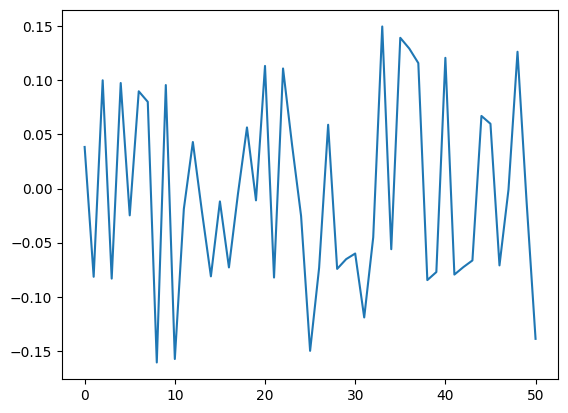

In [17]:
plt.plot(errors[0])

(<Figure size 6400x2300 with 1 Axes>, <Axes: >)

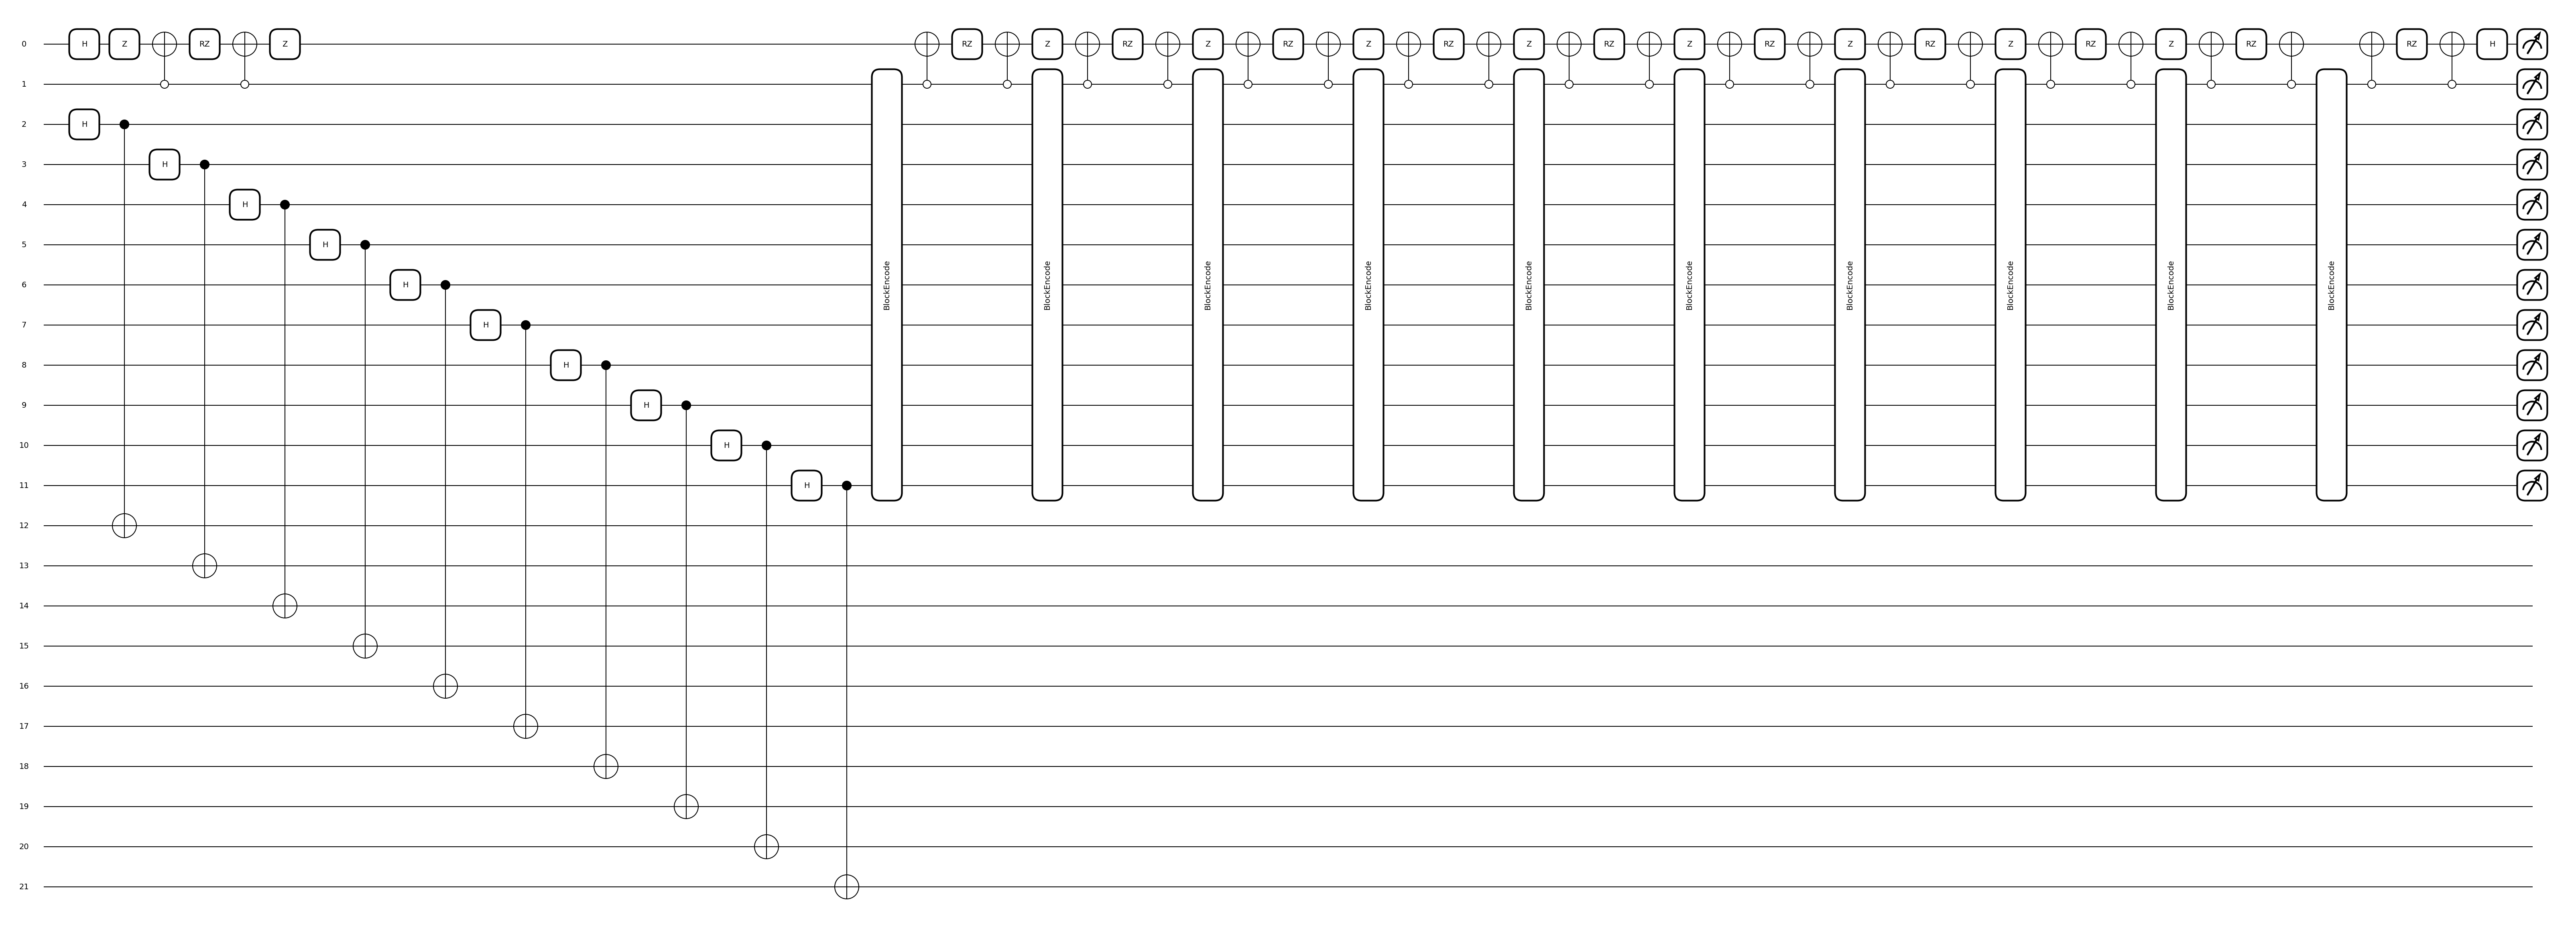

In [114]:
dev = qml.device(dev_name, wires=qbm.n_qubits({'aux','enc','sys'}))
        #dev = qml.device(dev_name, backend=backend,wires=self.n_qubits(),ibmqx_token=token)
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()

qml.draw_mpl(quantum_circuit)()

In [90]:
bit_strings=[]
for i in range(2**(qbm.n_hidden_nodes+qbm.dim_input)):
        # Convert the number to its binary representation and pad with leading zeros
            bit_string = bin(i)[2:].zfill(qbm.n_hidden_nodes+qbm.dim_input)
             
            bit_list = np.array([int(bit) for bit in bit_string])
            bit_strings.append(bit_list) 
            
      
sample = random.choices(bit_strings, k=1)

sample[0]

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0], requires_grad=True)

In [ ]:
import time

start=time.time()
#x=qbm.get_sample(shots=5)
x=qbm.get_average_configurations()
end=time.time()
print(x)
print(end-start)

In [ ]:
weights=qbm.H.θ

plt.plot(e)
testing_data, testing_labels = split_dataset_labels(testing_dataset)
encoded_data_test, bits_input_vector, num_features = qbm.binary_encode_data(
        testing_data, use_folding=True)




#training_data=numpy.expand_dims(training_data[:,0],axis=1)
outliers = qbm.get_binary_outliers(
dataset=testing_dataset, outlier_index=CLUSTER)
outliers=numpy.expand_dims(outliers[:,0],axis=1)
print(outliers)

points = qbm.get_binary_cluster_points(
dataset=testing_dataset, cluster_index=CLUSTER - 1)

points=numpy.expand_dims(points[:,0],axis=1)
print(points)
predict_points_cluster = np.zeros(len(points), dtype=int)
predict_points_outliers = np.zeros(len(outliers), dtype=int)
print("Outlier threshold: ", qbm.outlier_threshold)
print("Calculate outlier Energy")

outlier_energy = []
for index, outlier in enumerate(tqdm(outliers), 0):
    outlier = np.reshape(outlier, (qbm.dim_input))
    predict_points_outliers[index], this_outlier_energy = qbm.predict_point_as_outlier(
        outlier)
    outlier_energy.append(this_outlier_energy)
outlier_energy = np.array(outlier_energy)

o = outlier_energy.reshape((outlier_energy.shape[0]))

print("Calculate cluster energy")
cluster_point_energy = []

for index, point in enumerate(tqdm(points), 0):
    point = np.reshape(point, (qbm.dim_input))
    predict_points_cluster[index], this_cluster_point_energy = qbm.predict_point_as_outlier(
        point)
    cluster_point_energy.append(this_cluster_point_energy)
cluster_point_energy = np.array(cluster_point_energy)

c = cluster_point_energy.reshape((cluster_point_energy.shape[0]))

title='test'
#qbmqsp.src.utils.save_output(title="cluster_" + title, object=c)
#QBM.plot_energy_diff([o, c], qbm.outlier_threshold, title + ".pdf")

#QBM.plot_hist(c, o, qbm.outlier_threshold, "qbm_hist" + ".pdf")

########## OUTLIER CLASSIFICATION ##########
print('Outlier classification: Results...')
predict_points = np.concatenate(
    (predict_points_cluster, predict_points_outliers))

print("Predicted points test: ", predict_points)

true_points = np.concatenate(
    (np.zeros_like(cluster_point_energy), np.ones_like(outlier_energy)))

accuracy, precision, recall = accuracy_score(true_points, predict_points), precision_score(
    true_points, predict_points), recall_score(true_points, predict_points)
f1 = f1_score(true_points, predict_points)
tn, fp, fn, tp = confusion_matrix(
    true_points, predict_points, labels=[0, 1]).ravel()

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, \nNum True Negative: {tn}, Num False Negative: {fn}, Num True Positive: {tp}, Num False Positive: {fp}')

end = time.time()
print(f'Wallclock time: {(end-start):.2f} seconds')

print("Outlier threshold: ", dqbm.outlier_threshold)
print("Average clusterpoint energy: ", np.average(cluster_point_energy))
print("Outlier energy: ", outlier_energy)


In [ ]:
tn, fp, fn, tp

In [ ]:
dev = qml.device('default.qubit', wires=qbm.n_qubits())
@qml.qnode(dev)
def quantum_circuit():
    qbm._prepare()
    return qbm._measure()


qml.draw_mpl(quantum_circuit)()

In [ ]:
def generate_bit_strings(n):
    # List to store all bit strings
    bit_strings = []
    
    # There are 2^n bit strings of length n
    for i in range(2**n):
        # Convert the number to its binary representation and pad with leading zeros
        bit_string = bin(i)[2:].zfill(n)
        bit_strings.append(bit_string)
    
    return bit_strings

# Example usage
n = 3
bit_strings = generate_bit_strings(n)
for bit_string in bit_strings:
    print(bit_string)


In [ ]:
def generate_bit_strings_as_lists(n):
    # List to store all bit strings as lists of integers
    bit_strings = []
    
    # There are 2^n bit strings of length n
    for i in range(2**n):
        # Convert the number to its binary representation and pad with leading zeros
        bit_string = bin(i)[2:].zfill(n)
        
        # Convert the string to a list of integers
        bit_list = [int(bit) for bit in bit_string]
        
        # Append the list of integers to the bit_strings list
        bit_strings.append(bit_list)
    
    return bit_strings

In [ ]:
a=generate_bit_strings_as_lists(3)

In [4]:


len(generate_pauli_strings_tfim(10,7))

31

In [26]:
pos_neg=[1,0,2,1]


[0, 2, 1, 0, 0, 2]